## First theoretical calculations for an Achromatic Beam Line in First & Second Order 

## C. Mussolini and N. Charitonidis (for internal use only)

## TRANSPORT manual to be taken into consideration : https://cds.cern.ch/record/133647/files/CERN-80-04.pdf
##  And mathematical framework for the matrices theory : http://inspirehep.net/record/187522/files/slac-r-075.pdf

In [1]:
from math import *
import holoviews as hv
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
from scipy.linalg import block_diag
sy.init_printing()
#hv.notebook_extension('bokeh', 'matplotlib')
%matplotlib inline

print("Everything imported")

Everything imported


In [2]:
def Create_Drift_Space(drift_lenght_symbol):
   
    Ld = drift_lenght_symbol
    magnet = {'matrix' : sy.Matrix([[1,Ld],[0,1]]),
              'type'   : 'drift',
              'length' : Ld/2
             }
    return(magnet)

def Create_Focusing_Magnet(focusing_symbol, aperture):
    
    f = focusing_symbol      
    magnet = { 'matrix' : sy.Matrix([[1,0],[-1/f, 1]]), 
               'apt' : aperture,
               'type': 'focus',
               'length' : 0
             }
    return(magnet)
    
def Create_Defocusing_Magnet(focusing_symbol, aperture):
    
    f = focusing_symbol 
    magnet = { 'matrix' : sy.Matrix([[1,0],[1/f, 1]]), 
               'apt' : aperture,
               'type': 'defocus',
               'length' : 0
             }

    return(magnet)

In [3]:
def Full_R_Matrix(R_matrix_x, R_matrix_y): #This combines the x and y R matrices to easily extract the components
    
    R_matrix = sy.Matrix(block_diag(R_matrix_x, R_matrix_y))
    
    return(R_matrix)

def Matrix_eval(matrix, var_1, var_2, var_3, var_4, distance, focusing, a, b): #Evaluates a symbolic matrix into a numerical one
    
    expr = sy.lambdify([var_1, var_2, var_3, var_4], matrix, "numpy") 
    values = expr(distance, focusing, a, b)
    
    return(values)
    
def check_a_over_b(a,b): #This function checks for 0/0 and if it finds it returns a 0
    
    if a == 0 and b == 0:
        return(0)    
    elif b == 0:
        return(99999)
    
    else:
        return(a/b)
    
def Desired_Parms(R_matrix): #This extracts the ratios of R values we are interested in
    
    comp1 =  R_matrix[0,0]
    comp2 =  R_matrix[0,1]
    comp3 =  R_matrix[3,3]
    comp4 =  R_matrix[2,3]
    
    return(comp1, comp2, comp3, comp4)
    
def Construct_line(elements): #This function, given a list of lenses and drift spaces, multiplies them out 
                              #and returns the R matrix for each step.
    
    partial_Rs = []
    R_matrix = sy.Matrix([[1,0],[0,1]])
    
    for component in elements:
        R_matrix = component@R_matrix
        partial_Rs.append(R_matrix)
        
    return(partial_Rs)  
  
def Locate_Arrows(list_of_dict):#, list_of_variables_used_x):
    
    position = 0
    y = []    
    dy = []
    
    for dictionary in list_of_dict:
        
        if dictionary['type'] == 'defocus' : 
            
            y.append(dictionary['apt']/2)
            dy.append(dictionary['apt']/2)
            
        elif dictionary['type'] == 'focus':

            y.append(dictionary['apt'])
            dy.append(-dictionary['apt']/2)
            
    return(y,dy)

In [4]:
#enter the paraeters wanted here. Can be easily expanded

L_D = 10
init_dist = 5

In [5]:
f_x = sy.Symbol( 'f_x', real=True)
f_y = sy.Symbol( 'f_y', real=True)
Ld_x = sy.Symbol( 'Ld_x', real=True)
#Ld_x = f_x + f_x
#Ld_y = f_y + f_y
Ld_y = sy.Symbol( 'Ld_y', real=True)
a = sy.Symbol( 'a', real=True)
b = sy.Symbol( 'b', real=True)


focus_x = Create_Focusing_Magnet(f_x, 5)
focus_y = Create_Focusing_Magnet(f_y, 5)

defocus_x = Create_Defocusing_Magnet(f_x, 5)
defocus_y = Create_Defocusing_Magnet(f_y, 5)

double_focus_x = Create_Focusing_Magnet(0.5*f_x, 5)
double_focus_y = Create_Focusing_Magnet(0.5*f_y, 5)

double_defocus_x = Create_Defocusing_Magnet(0.5*f_x, 5)
double_defocus_y = Create_Defocusing_Magnet(0.5*f_y, 5)

drift_x = Create_Drift_Space(Ld_x)
drift_y = Create_Drift_Space(Ld_y)

first_drift_x = Create_Drift_Space(a)
first_drift_y = Create_Drift_Space(a)

last_drift_x = Create_Drift_Space(b)
last_drift_y = Create_Drift_Space(b)

list_of_variables_used_x = [Ld_x, a, f_x, b]
list_of_variables_used_y = [Ld_y, a, f_y, b]

values_of_vars_x = [L_D, init_dist]
values_of_vars_y = [L_D, init_dist]

In [6]:
#dicts_used_x = [ first_drift_x, focus_x, drift_x, double_defocus_x, drift_x, focus_x, last_drift_x]
#dicts_used_y = [ first_drift_y, defocus_y, drift_y, double_focus_y, drift_y, defocus_y, last_drift_y]

dicts_used_x = [ first_drift_x, focus_x,  drift_x, focus_x, last_drift_x]
dicts_used_y = [ first_drift_y, defocus_y, drift_y, defocus_y, last_drift_y]


#here we list the elements(ie quadrupoles and drifts) used in order

elements_used_x = []
elements_used_y = []

for dict_x, dict_y in zip(dicts_used_x, dicts_used_y):

    elements_used_x.append(dict_x['matrix'])
    elements_used_y.append(dict_y['matrix'])
    
#This block multiplies together the matrices given above, extractiong the R matrix for each step

R_in_x = sy.simplify(Construct_line(elements_used_x))
R_in_y = sy.simplify(Construct_line(elements_used_y))

In [7]:
focus = sy.lambdify([Ld_x, a], R_in_x[-1][1,0], 'numpy')
solutions_f = sy.solve(focus(L_D, init_dist), f_x)
if len(solutions_f)==0:
    f = 100000000
    print("Warning: solutions are independant of the focus!")
elif len(solutions_f)==1:
    f = sy.N(solutions_f[0]) #N is sympy for evaluating
else:
    
    f = sy.N(min(n for n in solutions_f if n > 0))

In [8]:
elem12 = sy.lambdify([Ld_x, f_x, a], R_in_x[-1][0,1], 'numpy')
solutions = sy.solve(elem12(L_D, f, init_dist))
if len(solutions)==0:
    fin_dist = 1000000
    print("Warning: solutions are independant of the final distance!")
elif len(solutions)==1:
    fin_dist = sy.N(solutions[0])
else:
    fin_dist = sy.N(min(n for n in solutions if n > 0)) 

In [9]:
values_of_vars_x.append(f)
values_of_vars_x.append(fin_dist)
values_of_vars_y.append(-f)
values_of_vars_y.append(fin_dist)

In [10]:
print("Focusing strength is: %3.3f" %(f))
print("Initial length %3.3f" %(init_dist))
print("Final lenght: %3.3f" %(fin_dist) )

Focusing strength is: 5.000
Initial length 5.000
Final lenght: 5.000


In [11]:
R_in_x = Matrix_eval(R_in_x, *list_of_variables_used_x, *values_of_vars_x)
R_in_y = Matrix_eval(R_in_y, *list_of_variables_used_y, *values_of_vars_y)


In [12]:
pos_magnets_x = [0]
pos_magnets_y = [0]
pos_elements_x = []
pos_elements_y = []


for dict_x, dict_y in zip(dicts_used_x, dicts_used_y):
    
    xval = sy.lambdify(list_of_variables_used_x, dict_x['length'])
    yval = sy.lambdify(list_of_variables_used_y, dict_y['length'])
    
    new_x = xval(*values_of_vars_x) + pos_magnets_x[-1]
    new_y = yval(*values_of_vars_y) + pos_magnets_y[-1]
    
    if new_x != pos_magnets_x[-1]:  
        pos_magnets_x.append( 2* new_x )
        
    if new_y != pos_magnets_y[-1]:
        pos_magnets_y.append( 2* new_y )

    pos_elements_x.append(new_x)
    pos_elements_y.append(new_y)
        
pos_magnets_x = pos_magnets_x[1:]
pos_magnets_y = pos_magnets_y[1:]

In [13]:
#Here we pull out the ratios we are interested in

ratios = []
R11 = []
R12 = []
R33 = []
R34 = []
#can easily remove one of loops here in future

for x, y in zip(R_in_x, R_in_y):
    ratios.append(Desired_Parms(Full_R_Matrix(x,y)))
    
for item in ratios:
    R11.append(item[0])
    R12.append(item[1])
    R33.append(item[2])
    R34.append(item[3])

In [14]:
Full_R_Matrix(R_in_x[-1],R_in_y[-1])

⎡-1.0   0     0     0  ⎤
⎢                      ⎥
⎢ 0    -1.0   0     0  ⎥
⎢                      ⎥
⎢ 0     0    -1.0   0  ⎥
⎢                      ⎥
⎣ 0     0     0    -1.0⎦

In [15]:
print("R matrix values are:")
if fin_dist > 0:
    print("[ %3.2f, %3.2f, %3.2f, %3.2f ]" %(R11[-1], R12[-1], R33[-1], R34[-1]))

else:
    print("Not allowing a telescope, but values would be")
    print("[ %3.2f, %3.2f, %3.2f, %3.2f ]" %(R11[-1], R12[-1], R33[-1], R34[-1]))

R matrix values are:
[ -1.00, 0.00, -1.00, 0.00 ]


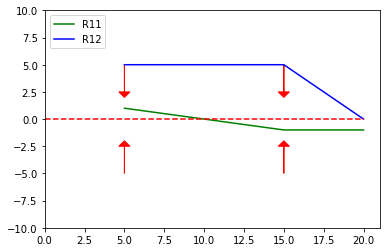

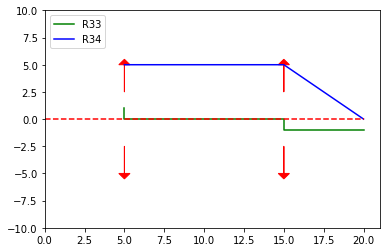

In [16]:
#Plot the various R values. Each element is at an integer value, but this can be easily changed later

plt.plot(pos_elements_x, R11, 'g', label = "R11" )
plt.plot(pos_elements_x, R12, 'b', label = "R12")
xy, xdy = Locate_Arrows(dicts_used_x)

for x,y,dx,dy in zip(pos_magnets_x, xy, np.zeros(len(pos_magnets_x)), xdy):
    plt.arrow(x, y, dx, dy, color = 'r', head_width=0.7, head_length=0.5)
    plt.arrow(x, -y, dx, -dy, color = 'r', head_width=0.7, head_length=0.5)

plt.plot([0, max(pos_elements_x)],[0, 0], '--r')
plt.xlim(left=0)
plt.ylim(-10,10)
plt.legend(loc = 2)
plt.show()

plt.plot(pos_elements_y, R33, 'g', label = "R33")
plt.plot(pos_elements_y, R34, 'b', label = "R34")
yy, ydy = Locate_Arrows(dicts_used_y)

for x,y,dx,dy in zip(pos_magnets_y, yy, np.zeros(len(pos_magnets_y)), ydy):
    plt.arrow(x, y, dx, dy, color = 'r', head_width=0.7, head_length=0.5)
    plt.arrow(x, -y, dx, -dy, color = 'r', head_width=0.7, head_length=0.5)

plt.plot([0, max(pos_elements_y)],[0, 0], '--r')
plt.ylim(-10,10)
plt.xlim(left=0)
plt.legend(loc = 2)
plt.show()

In [21]:
R11

In [22]:
R34

In [23]:
R33

In [24]:
pos_elements_x

In [25]:
pos_elements_y